In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool
import catboost as cb
from scrapping import df_new
from pandas.api.types import is_object_dtype
from pandas.api.types import is_datetime64_dtype
import catboost as cb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl
from keras.models import Sequential
from keras.layers import Dense, LSTM
import plotly.graph_objects as go
import plotly.express as px
from statistics import median
import copy
import yfinance as yf
import re
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2023-09-22 16:59:25.838116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 16:59:26.624785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
entered_ticket='AAPL'
df=df_new(entered_ticket)

In [4]:
df

,Date,Cash On Hand,Receivables,Inventory,Other Current Assets,Total Current Assets,"Property, Plant, And Equipment",Long-Term Investments,Goodwill And Intangible Assets,Other Long-Term Assets,Total Long-Term Assets,Total Assets,Total Current Liabilities,Long Term Debt,Other Non-Current Liabilities,Total Long Term Liabilities,Total Liabilities,Common Stock Net,Retained Earnings (Accumulated Deficit),Comprehensive Income,Share Holder Equity,Total Liabilities And Share Holders Equity,Revenue,Cost Of Goods Sold,Gross Profit,Research And Development Expenses,SG&A Expenses,Operating Expenses,Operating Income,Total Non-Operating Income/Expense,Pre-Tax Income,Income Taxes,Income After Taxes,Income From Continuous Operations,Net Income,EBITDA,EBIT,Basic Shares Outstanding,Shares Outstanding,Basic EPS,EPS - Earnings Per Share,Net Income/Loss,Total Depreciation And Amortization - Cash Flow,Other Non-Cash Items,Total Non-Cash Items,Change In Accounts Receivable,Change In Inventories,Change In Accounts Payable,Change In Assets/Liabilities,Total Change In Assets/Liabilities,Cash Flow From Operating Activities,"Net Change In Property, Plant, And Equipment",Net Change In Intangible Assets,Net Acquisitions/Divestitures,Net Change In Short-term Investments,Net Change In Long-Term Investments,Net Change In Investments - Total,Investing Activities - Other,Cash Flow From Investing Activities,Net Long-Term Debt,Net Current Debt,Debt Issuance/Retirement Net - Total,Net Common Equity Issued/Repurchased,Net Total Equity Issued/Repurchased,Total Common And Preferred Stock Dividends Paid,Financial Activities - Other,Cash Flow From Financial Activities,Net Cash Flow,Stock-Based Compensation,Common Stock Dividends Paid,FCF,Discount_rate,Discount_factor,DCF,Grow_rate,CDCF,Market_value,Intrinsic Value
0,2023-06-30,62482.00,39186.00,7351.00,13640.00,122659.00,43550.00,104061.00,0.00,64768.00,212379.00,335038.00,124963.00,98071.00,51730.00,149801.00,274764.00,70667.00,1408.00,-11801.00,60274.00,335038.00,81797.00,45384.00,36413.00,7442.00,5973.00,13415.00,22998.00,-265.00,22733.00,2852.00,19881.00,19881.00,19881.00,26050.00,22998.00,15697.61,15775.02,1.27,1.26,19881.00,3052.00,2698.00,5750.00,-1987.00,-22.00,3974.00,-1216.00,749.00,26380.00,-2093.00,0.00,0.00,3036.00,0.00,3036.00,-506.00,437.00,-2272.00,1989.00,-283.00,-17478.00,-17478.00,-3849.00,-2438.00,-24048.00,2769.00,2617.00,-3849.00,24287.00,0.05,0.48,11681.18,-0.05,771391.48,949412.56,60.18
1,2023-03-31,55872.00,35899.00,7482.00,13660.00,112913.00,43398.00,110461.00,0.00,65388.00,219247.00,332160.00,120075.00,97041.00,52886.00,149927.00,270002.00,69568.00,4336.00,-11746.00,62158.00,332160.00,94836.00,52860.00,41976.00,7457.00,6201.00,13658.00,28318.00,64.00,28382.00,4222.00,24160.00,24160.00,24160.00,31216.00,28318.00,15787.15,15847.05,1.53,1.52,24160.00,2898.00,1271.00,4169.00,5321.00,-741.00,-14689.00,10340.00,231.00,28560.00,-2916.00,0.00,0.00,5341.00,0.00,5341.00,-106.00,2319.00,-2250.00,254.00,-1996.00,-19594.00,-19594.00,-3650.00,-484.00,-25724.00,5155.00,2686.00,-3650.00,25644.00,0.05,0.52,13270.01,-0.15,759710.29,841125.52,53.08
2,2022-12-31,51355.00,54180.00,6820.00,16422.00,128777.00,42951.00,114095.00,0.00,60924.00,217970.00,346747.00,137286.00,99627.00,53107.00,152734.00,290020.00,66399.00,3240.00,-12912.00,56727.00,346747.00,117154.00,66822.00,50332.00,7709.00,6607.00,14316.00,36016.00,-393.00,35623.00,5625.00,29998.00,29998.00,29998.00,38932.00,36016.00,15892.72,15955.72,1.89,1.88,29998.00,2916.00,2588.00,5504.00,4275.00,-1807.00,-6075.00,2110.00,-1497.00,34005.00,-3787.00,0.00,0.00,2483.00,0.00,2483.00,-141.00,-1445.00,-1401.00,-8214.00,-9615.00,-19475.00,-19475.00,-3768.00,-2705.00,-35563.00,-3003.00,2905.00,-3768.00,30218.00,0.04,0.56,17070.63,0.45,746440.28,707633.62,44.35
3,2022-09-30,48304.00,60932.00,4946.00,21223.00,135405.00,42117.00,120805.00,0.00,54428.00,217350.00,352755.00,153982.00,98959.00,49142.00,148101.00,302083.00,64849.00,-3068.00,-11109.00,50672.00,352755.00,90146.0

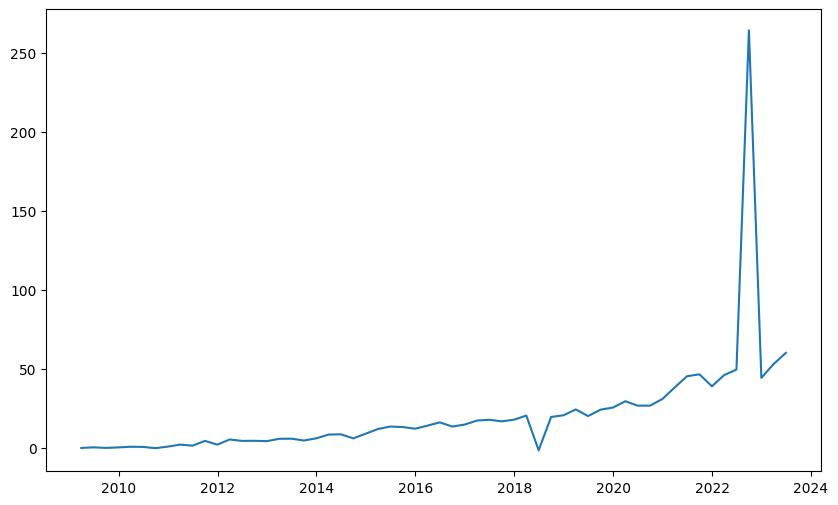

In [5]:
# z = np.polyfit(df['Intrinsic Value'], df.index, 1)
# p = np.poly1d(z)
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df['Intrinsic Value'])
# plt.plot(df['Date'], p(df.index),  "r--")
plt.show()

In [6]:
df_test=df.copy()

In [7]:
# Нормализуйте данные
data=df_test['FCF'][::-1]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))

# Разделите данные на обучающую и тестовую выборки
train_data=scaled_data
# train_data = scaled_data[:int(0.8 * len(df_test))]
# test_data = scaled_data[int(0.8 * len(df_test)):]

# Создайте функцию для создания последовательностей данных
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X_train, y_train = create_sequences(train_data, seq_length)
# X_test, y_test = create_sequences(test_data, seq_length)

X_test = scaled_data[-4-seq_length:-4]
X_test = X_test.reshape(1, seq_length, -1)

model = Sequential([
    LSTM(4, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(4),
    Dense(1)
])

# model.summary()

# Обучите модель на обучающей выборке
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1000)

2023-09-22 17:01:02.663047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:01:02.791180: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:01:02.791241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:01:02.793159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 17:01:02.793220: I tensorflow/compile

Epoch 1/1000


2023-09-22 17:01:06.854179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-22 17:01:07.027027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-22 17:01:07.051614: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0a1d39f930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-22 17:01:07.051645: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2023-09-22 17:01:07.087383: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2/2 [==============================] - 3s 10ms/step - loss: 0.1526
Epoch 2/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1488
Epoch 3/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1452
Epoch 4/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1416
Epoch 5/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1381
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1349
Epoch 7/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1313
Epoch 8/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1281
Epoch 9/1000


2023-09-22 17:01:07.315821: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 0s 6ms/step - loss: 0.1248
Epoch 10/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1215
Epoch 11/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1183
Epoch 12/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1154
Epoch 13/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1121
Epoch 14/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.1089
Epoch 15/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.1059
Epoch 16/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.1029
Epoch 17/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0998
Epoch 18/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0969
Epoch 19/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0941
Epoch 20/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0911
Epoch 21/1000
2/2 [==============================] - 0

In [8]:
next_quarter_data_fcf=scaler.inverse_transform(model.predict(X_test).reshape(-1, 1))
next_quarter_data_fcf

1/1 [==============================] - 0s 340ms/step


array([[19497.834]], dtype=float32)